In [1]:
import warnings
warnings.filterwarnings('ignore')

# Анализ настроений отзывов на приложения в Google Store и App Store

**Корректность проверена на:**
+ python 3.8.8
+ pandas 1.2.4
+ numpy 1.20.1
+ sklearn 1.1.2

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

In [3]:
#загрузим данные из файла
all_reviews = pd.read_csv('Reviews_CryptoApp.csv')
#посмотрим на них
all_reviews.head()

,rating,app_review_text,timestamp,userName,app_name,marketplace,country
0,4,"Great app. So far I am very new to this app, h...",2021-08-25 19:03:14,$cashguy$,Crypto.com,Apple App Store,us
1,5,Wonderful Crypto App Review Rating. I was so d...,2022-12-09 20:29:00,Joann172,Crypto.com,Apple App Store,us
2,5,Definitely sufficient wonderful app review. I ...,2023-01-13 19:40:15,Theodore$2G4,Crypto.com,Apple App Store,us
3,5,Excellent trading service app. I was so dissat...,2022-12-22 22:09:16,KayT07839$,Crypto.com,Apple App Store,us
4,5,A great crypto app 💯. I was impatient to carry...,2022-11-29 02:23:55,Maria Bronce 🍀🥰🍀,Crypto.com,Apple App Store,us


In [4]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rating           1000 non-null   int64 
 1   app_review_text  1000 non-null   object
 2   timestamp        1000 non-null   object
 3   userName         1000 non-null   object
 4   app_name         1000 non-null   object
 5   marketplace      1000 non-null   object
 6   country          1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


In [5]:
#Посмотрим на распределение данных по рейтингам
all_reviews.rating.value_counts()

5    571
1    222
4     97
2     60
3     50
Name: rating, dtype: int64

In [6]:
#подготовим данные для обучения
#возьмем данные с рейтингом 1 и 5 
train_data = all_reviews[all_reviews.rating==1].copy()
traindata_5 = all_reviews[all_reviews.rating==5].copy()
#для равного распределения обучающих данных возьмем отзывы с рейтингом 5 в том е количестве, что и с рейтингом 1
train_data = train_data.append(traindata_5[:all_reviews[all_reviews.rating==1].shape[0]])

In [7]:
train_data.rating.value_counts()

1    222
5    222
Name: rating, dtype: int64

In [8]:
#отделяем текст для анализа
texts = train_data['app_review_text']
#преобразуем негативную оценку в 0 и позитивную в 1
labels = np.array([0 if t==1 else 1 for t in train_data['rating']])

In [9]:
#разобъем данные на обучающий и тестовый наборы и перемешаем
X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.3, random_state=1, shuffle=True)

## Оценка качества работы разных классификаторов

In [10]:
#Pipeline для текстовой классификации
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [11]:
#оценим качество работы разных классификаторов
for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
    print(clf)
    print(cross_val_score(text_classifier(CountVectorizer(), TfidfTransformer(), clf()), X_train, y_train).mean())
    print("\n")

<class 'sklearn.linear_model._logistic.LogisticRegression'>
0.8225806451612904


<class 'sklearn.svm._classes.LinearSVC'>
0.8451612903225806


<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
0.8451612903225806




Видим, что метрика линейного SVM лучше всего

In [12]:
#Подготовка классификатора, обученного на всех данных
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LinearSVC())] )


clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', LinearSVC())])

In [13]:
#оценим точность на тестовой выборке
predicted = clf_pipeline.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

Accuracy: 0.8507462686567164


In [14]:
#расширим выборку и посмотрим на результат предсказаний
train_data_all = all_reviews[all_reviews.rating.isin([1,2,4,5])].copy()
labels_all = np.array([0 if t==1 or t ==2 else 1 for t in train_data_all['rating']])
predicted_all = clf_pipeline.predict(train_data_all['app_review_text'])
print("Accuracy:",metrics.accuracy_score(labels_all, predicted_all))

Accuracy: 0.8431578947368421


In [15]:
all_reviews['sentiment_score_1'] = clf_pipeline.predict(all_reviews['app_review_text'])
all_reviews.head()

,rating,app_review_text,timestamp,userName,app_name,marketplace,country,sentiment_score_1
0,4,"Great app. So far I am very new to this app, h...",2021-08-25 19:03:14,$cashguy$,Crypto.com,Apple App Store,us,0
1,5,Wonderful Crypto App Review Rating. I was so d...,2022-12-09 20:29:00,Joann172,Crypto.com,Apple App Store,us,1
2,5,Definitely sufficient wonderful app review. I ...,2023-01-13 19:40:15,Theodore$2G4,Crypto.com,Apple App Store,us,1
3,5,Excellent trading service app. I was so dissat...,2022-12-22 22:09:16,KayT07839$,Crypto.com,Apple App Store,us,1
4,5,A great crypto app 💯. I was impatient to carry...,2022-11-29 02:23:55,Maria Bronce 🍀🥰🍀,Crypto.com,Apple App Store,us,1


## Сделаем балансировку классов

In [16]:
#возьмем данные с рейтингом 1 и 5 
train_data_for_balance = all_reviews[all_reviews.rating.isin([1,5])].copy()
train_data_for_balance.rating.value_counts()

5    571
1    222
Name: rating, dtype: int64

In [17]:
#отделяем текст для анализа
texts_for_balance = train_data_for_balance['app_review_text']
#преобразуем негативную оценку в 0 и позитовную в 1
labels_for_balance = np.array([0 if t==1 else 1 for t in train_data_for_balance['rating']])

#разобъем данные на обучающий и тестовый наборы и перемешаем
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
        texts_for_balance, labels_for_balance, test_size=0.3, random_state=1, shuffle=True)

In [18]:
#создадим сбалансированную выборку для обучения
over_sampler = RandomOverSampler(random_state=42)
X = X_train_b.values.reshape(-1, 1)
X_over, y_over = over_sampler.fit_resample(X,y_train_b)

#оценим качество работы разных классификаторов на сбалансированных классах
for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
    print(clf)
    print(cross_val_score(text_classifier(CountVectorizer(), TfidfTransformer(), clf()), 
                           X_over.reshape(1,X_over.shape[0])[0], y_over).mean())
    print("\n")

<class 'sklearn.linear_model._logistic.LogisticRegression'>
0.9076497765659319


<class 'sklearn.svm._classes.LinearSVC'>
0.9409073695372264


<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
0.9372036658335225




Видим, что результат метрики линейного SVM на сбалансированных данных еще выше.

In [19]:
#Подготовка классификатора, обученного на сбаланстированных данных
clf_pipeline_balance = Pipeline([("vectorizer", TfidfVectorizer()),
                                ("classifier", LinearSVC())] )

#обучаем
clf_pipeline_balance.fit( X_over.reshape(1,X_over.shape[0])[0], y_over)
#посмотрим результаты предсказания
predicted_b = clf_pipeline_balance.predict(X_test_b)
print("Accuracy balance:",metrics.accuracy_score(y_test_b, predicted_b))

Accuracy balance: 0.8613445378151261


In [20]:
#посмотрим на точность при расширении выборки: рейтинги 1,2,4,5
train_data_all = all_reviews[all_reviews.rating.isin([1,2,4,5])].copy()
labels_all = np.array([0 if t==1 or t ==2 else 1 for t in train_data_all['rating']])
predicted_all = clf_pipeline_balance.predict(train_data_all['app_review_text'])
print("Accuracy:",metrics.accuracy_score(labels_all, predicted_all))

Accuracy: 0.9136842105263158


С балансировкой классов результат лучше!

In [21]:
all_reviews['sentiment_score_balance'] = clf_pipeline_balance.predict(all_reviews['app_review_text'])
all_reviews.head()

,rating,app_review_text,timestamp,userName,app_name,marketplace,country,sentiment_score_1,sentiment_score_balance
0,4,"Great app. So far I am very new to this app, h...",2021-08-25 19:03:14,$cashguy$,Crypto.com,Apple App Store,us,0,0
1,5,Wonderful Crypto App Review Rating. I was so d...,2022-12-09 20:29:00,Joann172,Crypto.com,Apple App Store,us,1,1
2,5,Definitely sufficient wonderful app review. I ...,2023-01-13 19:40:15,Theodore$2G4,Crypto.com,Apple App Store,us,1,1
3,5,Excellent trading service app. I was so dissat...,2022-12-22 22:09:16,KayT07839$,Crypto.com,Apple App Store,us,1,1
4,5,A great crypto app 💯. I was impatient to carry...,2022-11-29 02:23:55,Maria Bronce 🍀🥰🍀,Crypto.com,Apple App Store,us,1,1


## Попробуем Textblob и Vader

In [22]:
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Мария\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:
def polarity_TextBlob(text):
    x = TextBlob(text).sentiment.polarity
        
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

all_reviews['sentiment_score_TextB'] = all_reviews['app_review_text'].apply(lambda x : polarity_TextBlob(x))

In [24]:
def polarity_Vader(text):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)
    
all_reviews['sentiment_score_Vader'] = all_reviews['app_review_text'].apply(lambda x : polarity_Vader(x))

In [25]:
#посмотрим на полученные данные

In [26]:
all_reviews[all_reviews['sentiment_score_TextB']=='pos'][['rating','app_review_text']].head()

,rating,app_review_text
0,4,"Great app. So far I am very new to this app, h..."
1,5,Wonderful Crypto App Review Rating. I was so d...
2,5,Definitely sufficient wonderful app review. I ...
3,5,Excellent trading service app. I was so dissat...
4,5,A great crypto app 💯. I was impatient to carry...


In [27]:
all_reviews[all_reviews['sentiment_score_TextB']=='neg'][['rating','app_review_text']].head()

,rating,app_review_text
12,1,Doesn’t allow you to buy crypto after a while ...
19,1,Scam Alert! DO NOT INSTALL CRYPTO APP. UPDATE:...
26,3,Good and bad. I really like using this app to ...
31,3,Warning: Believe Every Horrible Review. I ende...
32,1,Shady business practices. BE AWARE AND LOOK AT...


In [28]:
all_reviews[all_reviews['sentiment_score_TextB']=='neu'].rating.value_counts()

5    55
1    18
4    10
2     5
3     5
Name: rating, dtype: int64

In [29]:
all_reviews[all_reviews['sentiment_score_TextB']=='neu'][['rating','app_review_text']].head()

,rating,app_review_text
60,5,just the way it should be
61,5,to the moon
74,5,Respect!
76,3,Is there any plan to add bone or leash I notic...
77,1,Trying to login... it will never go through


In [30]:
all_reviews[all_reviews['sentiment_score_Vader']=='pos'][['rating','app_review_text']].head()

,rating,app_review_text
63,5,Awesome app... User friendly... Love the features
64,5,Highly recommended for reliability and safety.
65,5,OK
69,5,best crypto app period.
71,5,great app and user friendly


In [31]:
all_reviews[all_reviews['sentiment_score_Vader']=='neg'][['rating','app_review_text']].head()

,rating,app_review_text
463,1,Another crypto scam!
564,1,stupid
690,1,"So mad and frustrated, that's all I can say."
779,1,"Not good, i like the old version"
877,1,Terrible P2P experience.


In [32]:
all_reviews[all_reviews['sentiment_score_Vader']=='neu'][['rating','app_review_text']].head()

,rating,app_review_text
0,4,"Great app. So far I am very new to this app, h..."
1,5,Wonderful Crypto App Review Rating. I was so d...
2,5,Definitely sufficient wonderful app review. I ...
3,5,Excellent trading service app. I was so dissat...
4,5,A great crypto app 💯. I was impatient to carry...


In [33]:
all_reviews[all_reviews['sentiment_score_Vader']=='neu'].rating.value_counts()

5    398
1    214
4     81
2     59
3     48
Name: rating, dtype: int64

Видим, что по негативные отзывы Vader определяет хорошо, но остальные не очень - много классифицирует, как нейтральные, но это не так. Откажемся от него.

In [35]:
#попробуем оценить способ TextBlob - добавим нейтральные к позитивным
all_reviews['sentiment_score_TextB2'] = np.array([0 if t=='neg' else 1 for t in all_reviews['sentiment_score_TextB']])

In [36]:
#переведём rating к этому же виду
all_reviews['sentiment_score_rating'] = np.array([0 if t==1 or t ==2 else 1 for t in all_reviews['rating']])
all_reviews.head()

,rating,app_review_text,timestamp,userName,app_name,marketplace,country,sentiment_score_1,sentiment_score_balance,sentiment_score_TextB,sentiment_score_Vader,sentiment_score_TextB2,sentiment_score_rating
0,4,"Great app. So far I am very new to this app, h...",2021-08-25 19:03:14,$cashguy$,Crypto.com,Apple App Store,us,0,0,pos,neu,1,1
1,5,Wonderful Crypto App Review Rating. I was so d...,2022-12-09 20:29:00,Joann172,Crypto.com,Apple App Store,us,1,1,pos,neu,1,1
2,5,Definitely sufficient wonderful app review. I ...,2023-01-13 19:40:15,Theodore$2G4,Crypto.com,Apple App Store,us,1,1,pos,neu,1,1
3,5,Excellent trading service app. I was so dissat...,2022-12-22 22:09:16,KayT07839$,Crypto.com,Apple App Store,us,1,1,pos,neu,1,1
4,5,A great crypto app 💯. I was impatient to carry...,2022-11-29 02:23:55,Maria Bronce 🍀🥰🍀,Crypto.com,Apple App Store,us,1,1,pos,neu,1,1


In [37]:
#попробуем понять, какой score более точный
#удалим данные с rating = 3
all_reviews_no_3 = all_reviews[all_reviews.rating!=3].copy()
all_reviews_no_3.describe()

,rating,sentiment_score_1,sentiment_score_balance,sentiment_score_TextB2,sentiment_score_rating
count,950.000000,950.000000,950.000000,950.000000,950.000000
mean,3.773684,0.586316,0.728421,0.856842,0.703158
std,1.705487,0.492753,0.445008,0.350418,0.457107
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000
50%,5.000000,1.000000,1.000000,1.000000,1.000000
75%,5.000000,1.000000,1.000000,1.000000,1.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000


По показателям mean(среднее) и std (стандартное отклонение) есть ощущение, что показатель sentiment_score_balance самый точный. Посмотрим еще с другой стороны.

In [38]:
df_difference_1 = all_reviews_no_3.loc[all_reviews_no_3.sentiment_score_rating != all_reviews_no_3.sentiment_score_1]
df_difference_balance = all_reviews_no_3.loc[all_reviews_no_3.sentiment_score_rating != all_reviews_no_3.sentiment_score_balance]
df_difference_TextBlob = all_reviews_no_3.loc[all_reviews_no_3.sentiment_score_rating != all_reviews_no_3.sentiment_score_TextB2]

print("Количество разнящихся оценок в первой оценке:", df_difference_1.shape[0])
print("Количество разнящихся оценок после балансировки:", df_difference_balance.shape[0])
print("Количество разнящихся оценок TextBlob:", df_difference_TextBlob.shape[0])

Количество разнящихся оценок в первой оценке: 149
Количество разнящихся оценок после балансировки: 82
Количество разнящихся оценок TextBlob: 204


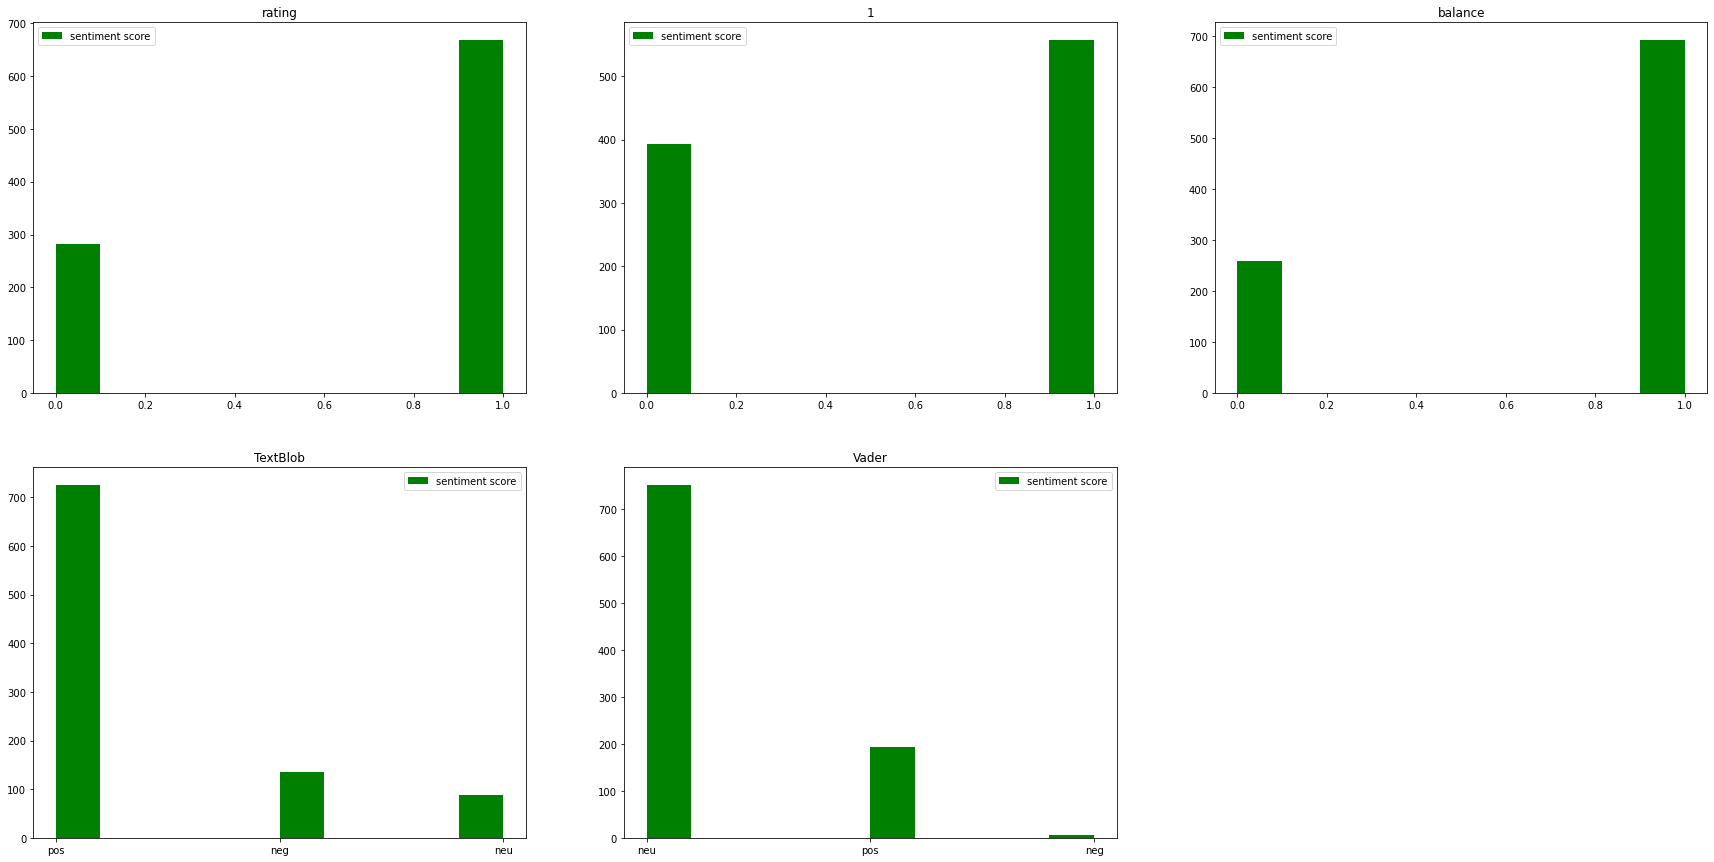

In [39]:
#попробуем посмотреть на гистограммы рейтингов и разные sentiment_score
#Sentiment Barchart
plt.figure(figsize=(30, 15))

plt.subplot(2,3,1)
plt.hist(all_reviews_no_3.sentiment_score_rating.values, color = 'g', label = 'sentiment score')
plt.legend()
plt.title('rating')

plt.subplot(2,3,2)
plt.hist(all_reviews_no_3.sentiment_score_1.values, color = 'g', label = 'sentiment score')
plt.legend()
plt.title('1')

plt.subplot(2,3,3)
plt.hist(all_reviews_no_3.sentiment_score_balance.values, color = 'g', label = 'sentiment score')
plt.legend()
plt.title('balance')

plt.subplot(2,3,4)
plt.hist(all_reviews_no_3.sentiment_score_TextB.values, color = 'g', label = 'sentiment score')
plt.legend()
plt.title('TextBlob')

plt.subplot(2,3,5)
plt.hist(all_reviews_no_3.sentiment_score_Vader.values, color = 'g', label = 'sentiment score')
plt.legend()
plt.title('Vader')

plt.show()

Будем считать, что оценка после балансировки классов самая точная. Её и возьмем для выгрузки в файл.

In [40]:
all_reviews['sentiment_score'] = np.array(['NEGATIVE' if t==0 else 'POSITIVE' for t in all_reviews.sentiment_score_balance])

Возможно, есть человеческий фактор в том, что люди писали в отзыве и какой ставили рейтинг. 

Как можно ещё улучшить:
+ попробовать вариант с заменой 'not':
    если встречается частичка «не» рядом с каком-то словом, будем считать, что в большинстве случаев «не» относится именно к этому слову, хотя, конечно, так может быть не всегда. Частичку «не» объединим со словом.

  def handle_negations(text):    
    return text.replace("n't", "not").replace("n 't", " not")
    X = X.apply(handle_negations)


+ можно попробовать N-граммы


+ можно попробовать Sentiment analysis из HuggingFace Transformers library 🤗

## Сохраним данные в .csv файл

Сделаем CSV-файл со следующей структурой: 
app name | username | timestamp | app review text | sentiment score | country (language) | marketplace ( Apple App Store or Google Play Store )

In [41]:
all_reviews.to_csv('Reviews_sentiment_score.csv', 
                   columns = ['app_name','userName','timestamp','app_review_text','sentiment_score','country','marketplace'],
                   index=False)

## Проанализируем полученный sentiment_score

In [42]:
import seaborn as sns

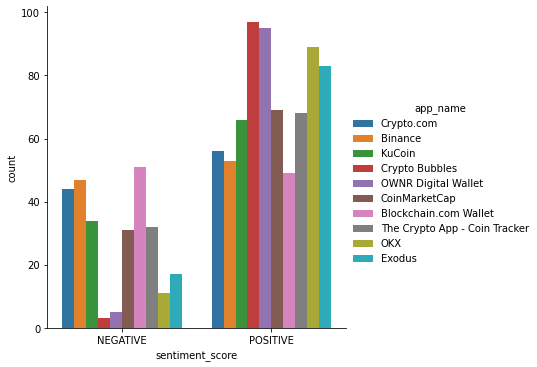

In [43]:
#сколько отзывов по каждому приложению
sns.catplot(x='sentiment_score', kind='count', hue='app_name', data=all_reviews);

In [44]:
all_reviews.sentiment_score.value_counts()

POSITIVE    725
NEGATIVE    275
Name: sentiment_score, dtype: int64